In [109]:
!pip install statsmodels
!pip install geopy

In [110]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.statespace.sarimax import SARIMAX
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [111]:
# Load the file
reported_numbers = pd.read_excel('system2_case_study_reported_numbers.xlsx')
location_info = pd.read_csv('system2_case_study_transaction_data_location_info.csv')
monthly_sales = pd.read_csv('system2_case_study_transaction_data_monthly_sales_by_locationid.csv')
webscrape_data = pd.read_csv('system2_case_study_webscrape_data_locations.csv')

reported_numbers['period_end_dt'] = pd.to_datetime(reported_numbers['period_end_dt'])
location_info['est_open_date'] = pd.to_datetime(location_info['est_open_date'])
location_info['est_close_date'] = pd.to_datetime(location_info['est_close_date'])
monthly_sales['period_start'] = pd.to_datetime(monthly_sales['period_start'])
monthly_sales['period_end'] = pd.to_datetime(monthly_sales['period_end'])

In [112]:
# Check for missing values
print(reported_numbers.isna().sum())
print(location_info.isna().sum())
print(monthly_sales.isna().sum())
print(webscrape_data.isna().sum())

entity           0
metric           0
period_end_dt    0
reported_yoy     1
dtype: int64
locationid        0
est_open_date     0
est_close_date    0
dtype: int64
symbol           0
locationid       0
period_start     0
period_end       0
label            0
amount          29
dtype: int64
address           0
as_of_date        0
city              0
phone             0
state             0
location_id       0
store_services    0
title             0
url               0
zipcode           0
postcode          0
latitude          0
longitude         0
dtype: int64


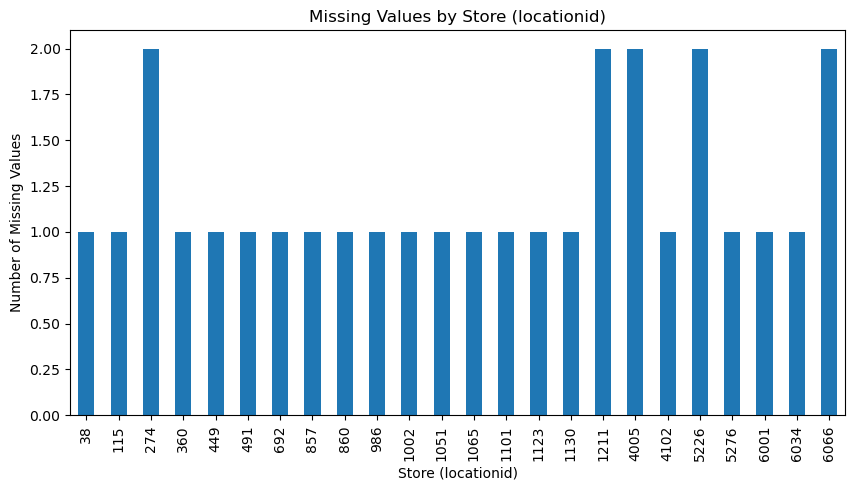

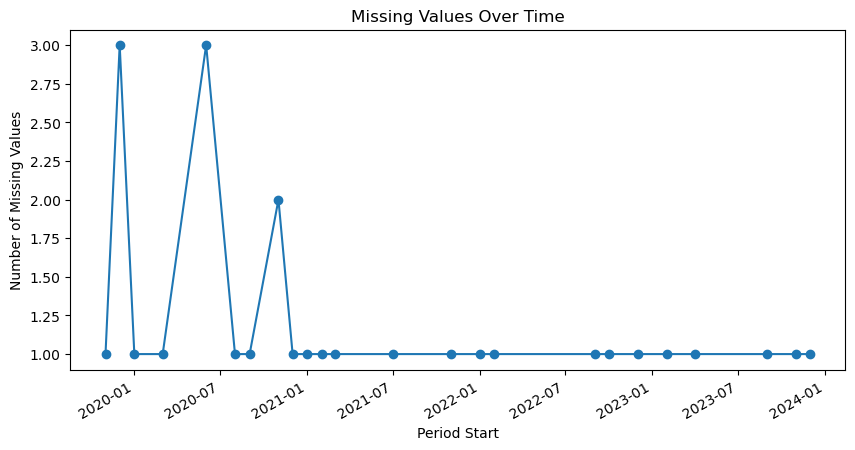

In [113]:
# Investigate missing values 
missing_by_store = monthly_sales[monthly_sales['amount'].isna()].groupby('locationid').size()
missing_by_period = monthly_sales[monthly_sales['amount'].isna()].groupby('period_start').size()

missing_by_store.plot(kind='bar', figsize=(10, 5))
plt.title("Missing Values by Store (locationid)")
plt.xlabel("Store (locationid)")
plt.ylabel("Number of Missing Values")
plt.show()

missing_by_period.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Missing Values Over Time")
plt.xlabel("Period Start")
plt.ylabel("Number of Missing Values")
plt.show()

In [114]:
# Fill missing values with average sales 
average_sales = monthly_sales['amount'].mean()
monthly_sales['amount'] = monthly_sales['amount'].fillna(average_sales)

## Q1: Forecasting Reported Brand Comparable Sales for 2022 Q4

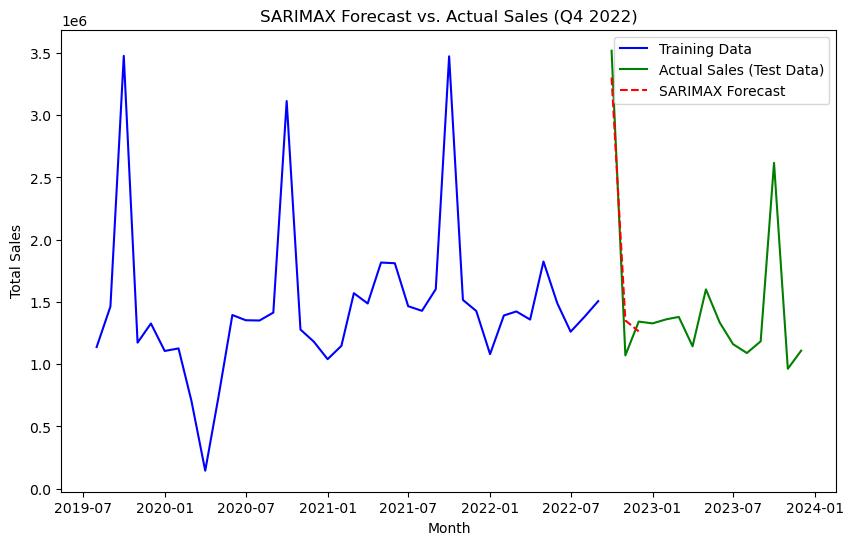

Forecasted Sales for Q4 2022:
2022-10-01    3.302790e+06
2022-11-01    1.351200e+06
2022-12-01    1.263884e+06
Freq: MS, Name: predicted_mean, dtype: float64


In [116]:
sales_data = monthly_sales.groupby('period_start')['amount'].sum().asfreq('MS')

train_data = sales_data[:'2022-09'] 
test_data = sales_data['2022-10':] 

sarimax_model = SARIMAX(
    train_data, 
    order=(3, 1, 0),  
    seasonal_order=(1, 1, 0, 12) 
)
sarimax_result = sarimax_model.fit(disp=False)

forecast = sarimax_result.predict(start='2022-10-01', end='2022-12-01')

plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Actual Sales (Test Data)', color='green')
plt.plot(forecast, label='SARIMAX Forecast', color='red', linestyle='--')
plt.title('SARIMAX Forecast vs. Actual Sales (Q4 2022)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

print("Forecasted Sales for Q4 2022:")
print(forecast)

In [117]:
q4_2021_sales = sales_data['2021-10-01':'2021-12-31'].sum()
q4_2022_forecast = forecast['2022-10-01':'2022-12-31'].sum()

yoy_change_q4 = ((q4_2022_forecast - q4_2021_sales) / q4_2021_sales) * 100

print(f"Actual Q4 2021 Sales: {q4_2021_sales:,.2f}")
print(f"Forecasted Q4 2022 Sales: {q4_2022_forecast:,.2f}")
print(f"YoY Total Change (Q4 2022 vs Q4 2021): {yoy_change_q4:.2f}%")

Actual Q4 2021 Sales: 6,416,820.46
Forecasted Q4 2022 Sales: 5,917,873.82
YoY Total Change (Q4 2022 vs Q4 2021): -7.78%


In [118]:
mae = mean_absolute_error(sales_data['2022-10-01':'2022-12-31'], forecast['2022-10-01':'2022-12-31'])
rmse = np.sqrt(mean_squared_error(sales_data['2022-10-01':'2022-12-31'], forecast['2022-10-01':'2022-12-31']))
actual = sales_data['2022-10-01':'2022-12-31']
predicted = forecast['2022-10-01':'2022-12-31']
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

r2 = r2_score(sales_data['2022-10-01':'2022-12-31'], forecast['2022-10-01':'2022-12-31'])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 191299.14
RMSE: 208913.60
MAPE: 12.71%
R²: 0.9636


In [119]:
closed_stores = location_info[location_info['est_close_date'] <= '2022-12-31']['locationid']

opened_stores_2022 = location_info[
    (location_info['est_open_date'] >= '2022-01-01') &
    (location_info['est_open_date'] <= '2022-12-31')
]['locationid']


q4_2021_sales = monthly_sales[
    (monthly_sales['period_start'] >= '2021-10-01') & 
    (monthly_sales['period_start'] <= '2021-12-31')
]

closed_store_sales_2021 = q4_2021_sales[q4_2021_sales['locationid'].isin(closed_stores)]['amount'].sum()

# Adjusted Q4 2021 Sales (only comparable stores)
adjusted_q4_2021_sales = q4_2021_sales['amount'].sum() - closed_store_sales_2021
q4_2022_sales = forecast.sum()  

new_store_sales_2022 = monthly_sales[
    (monthly_sales['locationid'].isin(opened_stores_2022)) & 
    (monthly_sales['period_start'] >= '2022-10-01') &
    (monthly_sales['period_start'] <= '2022-12-31')
]['amount'].sum()

# Adjusted Q4 2022 Sales (only comparable stores)
adjusted_q4_2022_sales = q4_2022_sales - new_store_sales_2022
yoy_comparable_change = ((adjusted_q4_2022_sales - adjusted_q4_2021_sales) / adjusted_q4_2021_sales) * 100

print(f"Adjusted Q4 2021 Sales: {adjusted_q4_2021_sales:.2f}")
print(f"Adjusted Q4 2022 Sales: {adjusted_q4_2022_sales:.2f}")
print(f"YoY Comparable Change for 2023 Q4: {yoy_comparable_change:.2f}%")

Adjusted Q4 2021 Sales: 6128134.32
Adjusted Q4 2022 Sales: 5716503.88
YoY Comparable Change for 2023 Q4: -6.72%


The forecasted YoY Comparable Change for 2023 Q4: -6.72%

## Q2: Forecasting Reported Brand Comparable Sales for 2023 Q1Q2Q3

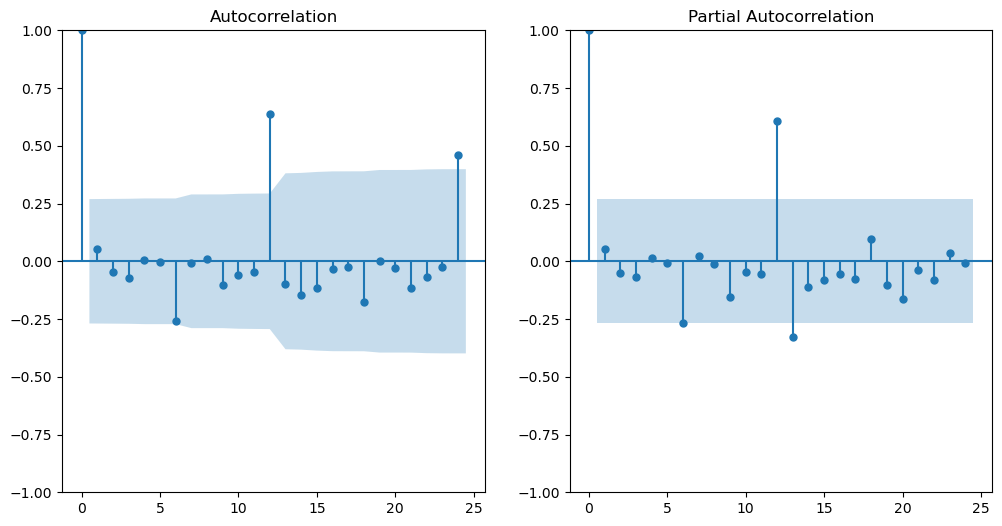

In [121]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(sales_data, lags=24, ax=plt.gca())  # Check up to 24 lags

plt.subplot(122)
plot_pacf(sales_data, lags=24, ax=plt.gca())

plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anacond

Forecast for Q1 2023:
 2023-01-01    1.143995e+06
2023-02-01    1.350946e+06
2023-03-01    1.485461e+06
Freq: MS, Name: predicted_mean, dtype: float64
Forecast for Q2 2023:
 2023-04-01    1.277374e+06
2023-05-01    1.723398e+06
2023-06-01    1.489837e+06
Freq: MS, Name: predicted_mean, dtype: float64
Forecast for Q3 2023:
 2023-07-01    1.099606e+06
2023-08-01    1.171959e+06
2023-09-01    1.315877e+06
Freq: MS, Name: predicted_mean, dtype: float64


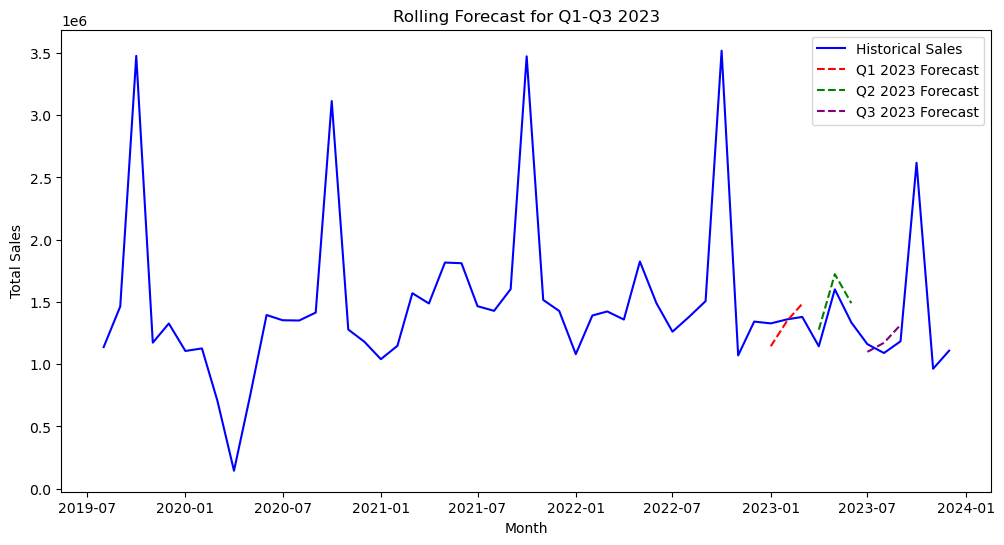

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def forecast_sales(train_data, start_date, end_date):
    model = SARIMAX(
        train_data, 
        order=(1, 1, 1),  # Simpler ARIMA component for stability
        seasonal_order=(1, 1, 1, 12)  # Annual seasonality
    )
    result = model.fit(disp=False)
    forecast = result.predict(start=start_date, end=end_date)
    return forecast

q1_2023_forecast = forecast_sales(
    train_data=sales_data['2019-01-01':'2022-12-31'],  # Use multiple years for stability
    start_date='2023-01-01', 
    end_date='2023-03-01'
)

updated_train_data = sales_data['2019-01-01':'2023-03-01']

q2_2023_forecast = forecast_sales(
    train_data=updated_train_data, 
    start_date='2023-04-01', 
    end_date='2023-06-01'
)
updated_train_data = sales_data['2019-01-01':'2023-06-01']

q3_2023_forecast = forecast_sales(
    train_data=updated_train_data, 
    start_date='2023-07-01', 
    end_date='2023-09-01'
)

print("Forecast for Q1 2023:\n", q1_2023_forecast)
print("Forecast for Q2 2023:\n", q2_2023_forecast)
print("Forecast for Q3 2023:\n", q3_2023_forecast)

plt.figure(figsize=(12, 6))
plt.plot(sales_data, label='Historical Sales', color='blue')
plt.plot(q1_2023_forecast, label='Q1 2023 Forecast', color='red', linestyle='--')
plt.plot(q2_2023_forecast, label='Q2 2023 Forecast', color='green', linestyle='--')
plt.plot(q3_2023_forecast, label='Q3 2023 Forecast', color='purple', linestyle='--')
plt.title('Rolling Forecast for Q1-Q3 2023')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [123]:
actual_q1 = sales_data['2023-01-01':'2023-03-01'].values
actual_q2 = sales_data['2023-04-01':'2023-06-01'].values
actual_q3 = sales_data['2023-07-01':'2023-09-01'].values

q1_forecast_values = q1_2023_forecast.values
q2_forecast_values = q2_2023_forecast.values
q3_forecast_values = q3_2023_forecast.values

# Define a function to evaluate model performance
def calculate_metrics(actual, forecast, quarter):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    r2 = r2_score(actual, forecast)
    
    print(f"Metrics for {quarter}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    print()

calculate_metrics(actual_q1, q1_forecast_values, "Q1 2023")
calculate_metrics(actual_q2, q2_forecast_values, "Q2 2023")
calculate_metrics(actual_q3, q3_forecast_values, "Q3 2023")

Metrics for Q1 2023:
MAE: 99740.28
RMSE: 122589.24
MAPE: 7.40%
R²: -31.6829

Metrics for Q2 2023:
MAE: 136923.52
RMSE: 137604.20
MAPE: 10.31%
R²: 0.4611

Metrics for Q3 2023:
MAE: 91741.63
RMSE: 96405.81
MAPE: 7.98%
R²: -4.8138



In [124]:
def calculate_yoy_comparable_change(sales_data, location_info, quarter_start_2022, quarter_end_2022, 
                                    quarter_start_2023, quarter_end_2023):
    closed_stores = location_info[location_info['est_close_date'] <= '2022-12-31']['locationid']

    opened_stores_2022 = location_info[
        (location_info['est_open_date'] >= '2022-01-01') & 
        (location_info['est_open_date'] <= '2022-12-31')
    ]['locationid']

    sales_2022 = sales_data[
        (sales_data['period_start'] >= quarter_start_2022) & 
        (sales_data['period_start'] <= quarter_end_2022)
    ]

    closed_store_sales_2022 = sales_2022[sales_2022['locationid'].isin(closed_stores)]['amount'].sum()
    adjusted_sales_2022 = sales_2022['amount'].sum() - closed_store_sales_2022

    sales_2023 = sales_data[
        (sales_data['period_start'] >= quarter_start_2023) & 
        (sales_data['period_start'] <= quarter_end_2023)
    ]

    new_store_sales_2023 = sales_2023[sales_2023['locationid'].isin(opened_stores_2022)]['amount'].sum()
    adjusted_sales_2023 = sales_2023['amount'].sum() - new_store_sales_2023

    yoy_change = ((adjusted_sales_2023 - adjusted_sales_2022) / adjusted_sales_2022) * 100

    return adjusted_sales_2022, adjusted_sales_2023, yoy_change

# Calculate YoY comparable changes for Q1, Q2, Q3 2023

# Q1 2023
q1_2022_start, q1_2022_end = '2022-01-01', '2022-03-01'
q1_2023_start, q1_2023_end = '2023-01-01', '2023-03-01'
adj_q1_2022, adj_q1_2023, yoy_q1 = calculate_yoy_comparable_change(
    monthly_sales, location_info, q1_2022_start, q1_2022_end, q1_2023_start, q1_2023_end)
print(f"Q1 2022 Adjusted Sales: {adj_q1_2022:.2f}, Q1 2023 Adjusted Sales: {adj_q1_2023:.2f}, YoY Change: {yoy_q1:.2f}%")

# Q2 2023
q2_2022_start, q2_2022_end = '2022-04-01', '2022-06-01'
q2_2023_start, q2_2023_end = '2023-04-01', '2023-06-01'
adj_q2_2022, adj_q2_2023, yoy_q2 = calculate_yoy_comparable_change(
    monthly_sales, location_info, q2_2022_start, q2_2022_end, q2_2023_start, q2_2023_end)
print(f"Q2 2022 Adjusted Sales: {adj_q2_2022:.2f}, Q2 2023 Adjusted Sales: {adj_q2_2023:.2f}, YoY Change: {yoy_q2:.2f}%")

# Q3 2023
q3_2022_start, q3_2022_end = '2022-07-01', '2022-09-01'
q3_2023_start, q3_2023_end = '2023-07-01', '2023-09-01'
adj_q3_2022, adj_q3_2023, yoy_q3 = calculate_yoy_comparable_change(
    monthly_sales, location_info, q3_2022_start, q3_2022_end, q3_2023_start, q3_2023_end)
print(f"Q3 2022 Adjusted Sales: {adj_q3_2022:.2f}, Q3 2023 Adjusted Sales: {adj_q3_2023:.2f}, YoY Change: {yoy_q3:.2f}%")

Q1 2022 Adjusted Sales: 3762683.29, Q1 2023 Adjusted Sales: 3939065.08, YoY Change: 4.69%
Q2 2022 Adjusted Sales: 4496398.33, Q2 2023 Adjusted Sales: 3946142.52, YoY Change: -12.24%
Q3 2022 Adjusted Sales: 3979554.56, Q3 2023 Adjusted Sales: 3318078.49, YoY Change: -16.62%


The forecasted YoY comparable changes for Q1, Q2, Q3 2023 are 4.69%, -12.24%, -16.62%.

## Q3: Determine Store Closures by Sales Trend and Proximity to the Closet Store

In [126]:
# Identify Active Stores (no close date or closing after 2024-09-01)
active_stores = location_info[
    (location_info['est_close_date'].isna()) | 
    (location_info['est_close_date'] >= '2024-09-01')
]

active_store_sales = monthly_sales[
    monthly_sales['locationid'].isin(active_stores['locationid'])
]

store_trends = []

for location_id in active_store_sales['locationid'].unique():
    store_sales = active_store_sales[active_store_sales['locationid'] == location_id]
    store_sales = store_sales.sort_values(by='period_start') 

    X = np.array(range(len(store_sales))).reshape(-1, 1) 
    y = store_sales['amount'].values.reshape(-1, 1) 

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0][0] 
    store_trends.append((location_id, slope))

trends_df = pd.DataFrame(store_trends, columns=['location_id', 'Sales Trend (Slope)'])

likely_to_close = trends_df[trends_df['Sales Trend (Slope)'] < -0]
likely_to_close = likely_to_close.sort_values(by='Sales Trend (Slope)', ascending=True)

print("Stores Likely to Close (Negative Sales Trends):")
print(likely_to_close)

Stores Likely to Close (Negative Sales Trends):
     location_id  Sales Trend (Slope)
24          1002         -2853.801884
61           109          -350.106713
303          520          -331.274239
89           117          -323.257520
669           57          -308.598917
..           ...                  ...
152          239            -0.406889
128         1515            -0.324337
122         1506            -0.249875
406          600            -0.088203
451          628            -0.066128

[240 rows x 2 columns]


In [127]:
likely_to_close = pd.merge(
    likely_to_close,
    webscrape_data[['location_id', 'latitude', 'longitude', 'state', 'address']],
    left_on='location_id',
    right_on='location_id',
    how='inner'
)

def nearest_store_distance(row, store_data):
    distances = store_data.apply(
        lambda x: geodesic(
            (row['latitude'], row['longitude']),
            (x['latitude'], x['longitude'])
        ).miles,
        axis=1
    )
    return distances[distances > 0].min() 

likely_to_close['nearest_store_distance'] = likely_to_close.apply(
    lambda row: nearest_store_distance(row, likely_to_close), axis=1
)

closure_candidates = likely_to_close[
    (likely_to_close['Sales Trend (Slope)'] < 0) & 
    (likely_to_close['nearest_store_distance'] <= 10)
]

print("Stores Recommended for Closure (Negative Trends + Close Proximity):")
print(closure_candidates[['location_id', 'state', 'address', 
                          'Sales Trend (Slope)', 'nearest_store_distance']])

closure_candidates.to_csv('closure_candidates.csv', index=False)

Stores Recommended for Closure (Negative Trends + Close Proximity):
     location_id       state                   address  Sales Trend (Slope)  \
0            520  California   1441 W Imperial Highway          -331.274239   
2            710  New Jersey                  385 NJ-3          -260.690938   
3            511    Michigan      32469 Gratiot Avenue          -243.049857   
5            513    Michigan         23195 Outer Drive          -136.192646   
7            529    Michigan           12220 Hall Road          -134.084698   
..           ...         ...                       ...                  ...   
181           76  California     3837 S Bristol Street            -1.332187   
183          705     Florida   3401 North Miami Avenue            -1.144903   
187          239     Georgia         4281 Roswell Road            -0.406889   
189         1506  California  25361 Crenshaw Boulevard            -0.249875   
190          600    Maryland           3235 Donnell Dr         

## Q4: Insights or Challenges 

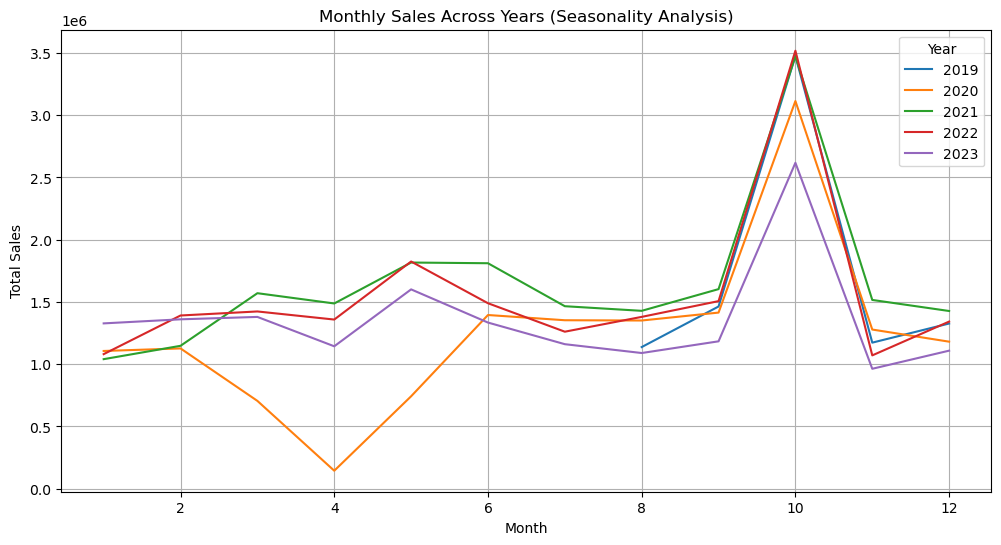

In [129]:
monthly_sales['year'] = monthly_sales['period_start'].dt.year
monthly_sales['month'] = monthly_sales['period_start'].dt.month

monthly_sales_agg = monthly_sales.groupby(['year', 'month'])['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
for year in monthly_sales_agg['year'].unique():
    yearly_data = monthly_sales_agg[monthly_sales_agg['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['amount'], label=f'{year}')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Across Years (Seasonality Analysis)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

Compelling Characteristics:
- Strong Seasonal Sales Trend: The chart shows significant spikes in sales towards the end of the year, indicating that Party City likely capitalizes on major holidays, such as Halloween, Christmas, New Year. This seasonality could suggest Party City has a strong market position in seasonal events, parties, and celebrations.
- Predictable Demand Cycles: The predictable sales spikes can help with planning inventories and marketing campaigns effectively. Party City may leverage these predictable cycles to optimize supply chains and enhance customer experience during high-demand seasons.

Problematic Characteristics:
- Heavy Reliance on Seasonal Events: The data shows a sharp sales increase followed by a steep drop. This suggests overdependence on specific seasons (like Q4). The absence of a steady growth trend across non-holiday months could indicate weak year-round demand.
- Declining Sales Trend Over Time: With total sales declining year-over-year (excluding 2020), Party City’s overall market performance is weakening. This might suggest diminishing brand relevance, competition, or shifting consumer preferences.

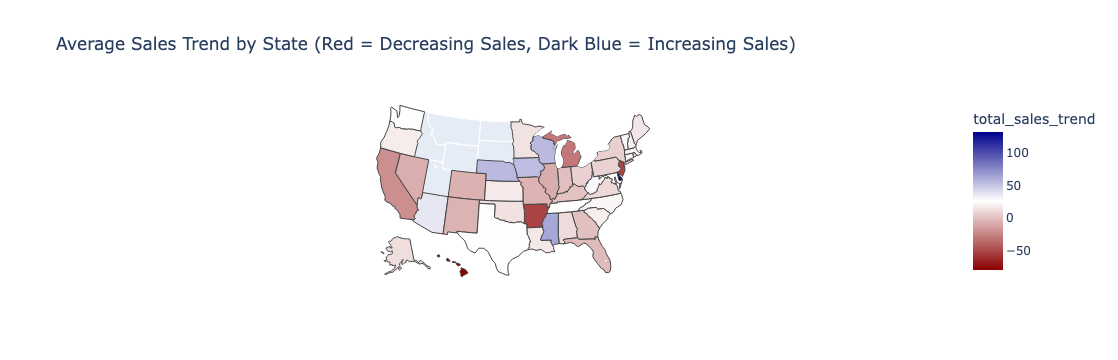

In [151]:
sales_with_location = pd.merge(
    monthly_sales.rename(columns={'locationid': 'location_id'}), 
    webscrape_data[['location_id', 'state', 'latitude', 'longitude']],
    on='location_id',
    how='inner'
)

sales_with_trends = pd.merge(
    sales_with_location,
    trends_df[['location_id', 'Sales Trend (Slope)']],
    on='location_id',
    how='inner'
)

state_profitability = sales_with_trends.groupby('state').agg(
    total_avg_sales=('amount', 'mean'),   
    total_sales_trend=('Sales Trend (Slope)', 'mean')
).reset_index()

state_profitability['state'] = state_profitability['state'].map(state_abbreviations)

fig = px.choropleth(
    state_profitability,
    locations='state',
    locationmode='USA-states',
    color='total_sales_trend',
    color_continuous_scale=[
        (0.0, "darkred"),  
        (0.5, "white"),     
        (1.0, "darkblue")  
    ],
    range_color=[
        state_profitability['total_sales_trend'].min(), 
        state_profitability['total_sales_trend'].max()
    ],
    hover_name='state',
    hover_data=['total_avg_sales', 'total_sales_trend'],
    scope='usa',
    title='Average Sales Trend by State (Red = Decreasing Sales, Dark Blue = Increasing Sales)'
)

fig.show()

Red Areas (Decreasing Sales):
- States with darker red shades, such as Arkansas, exhibit the steepest decline in sales trends, suggesting that stores or markets in these areas are underperforming. Potential store closures if trends are unsustainable.

Blue Areas (Increasing Sales):
- States like Maryland and neighboring areas show a slight blue trend, reflecting moderate or improving sales. These states may be opportunities for further growth and expansion to capitalize on growing demand.

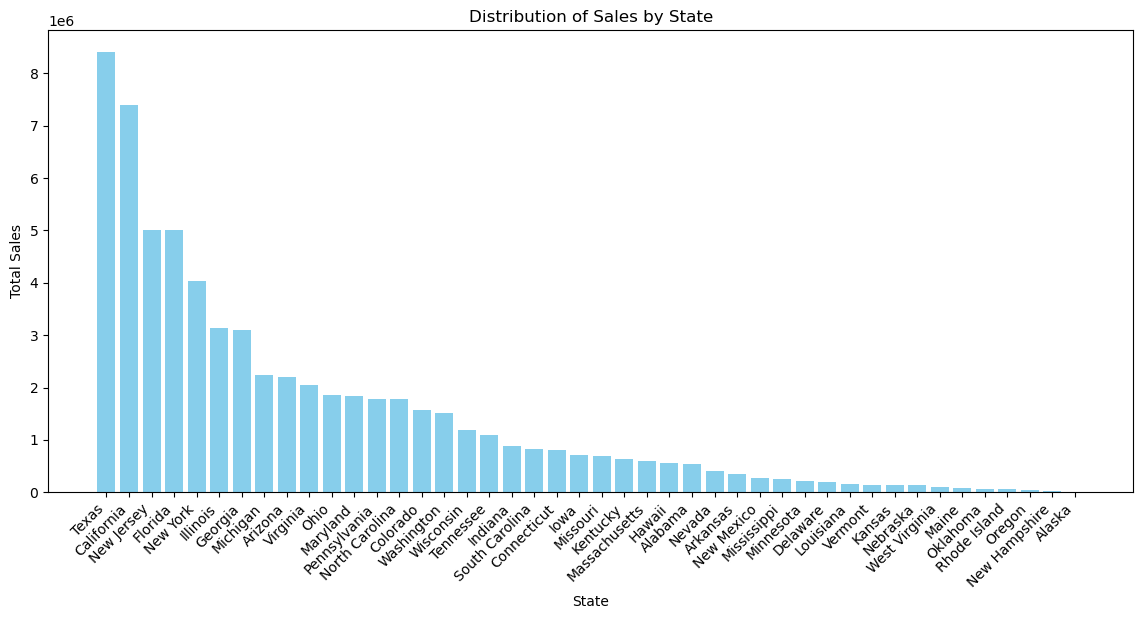

In [141]:
sales_by_location = monthly_sales.groupby('location_id')['amount'].sum().reset_index()

sales_with_state = pd.merge(
    sales_by_location, 
    webscrape_data[['location_id', 'state']], 
    on='location_id', 
    how='left'
)

sales_by_state = sales_with_state.groupby('state')['amount'].sum().reset_index()
sales_by_state = sales_by_state.sort_values(by='amount', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sales_by_state['state'], sales_by_state['amount'], color='skyblue')

plt.xticks(rotation=45, ha='right')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Distribution of Sales by State')

plt.show()

Total Sales by State
- Highly Concentrated Sales: A few states like Texas, California, and New Jersey contribute the largest portion of total sales, showing that Party City relies heavily on performance in key markets.
- Regional Imbalance: Several states contribute minimal total sales, which suggests limited brand presence or demand in those areas.

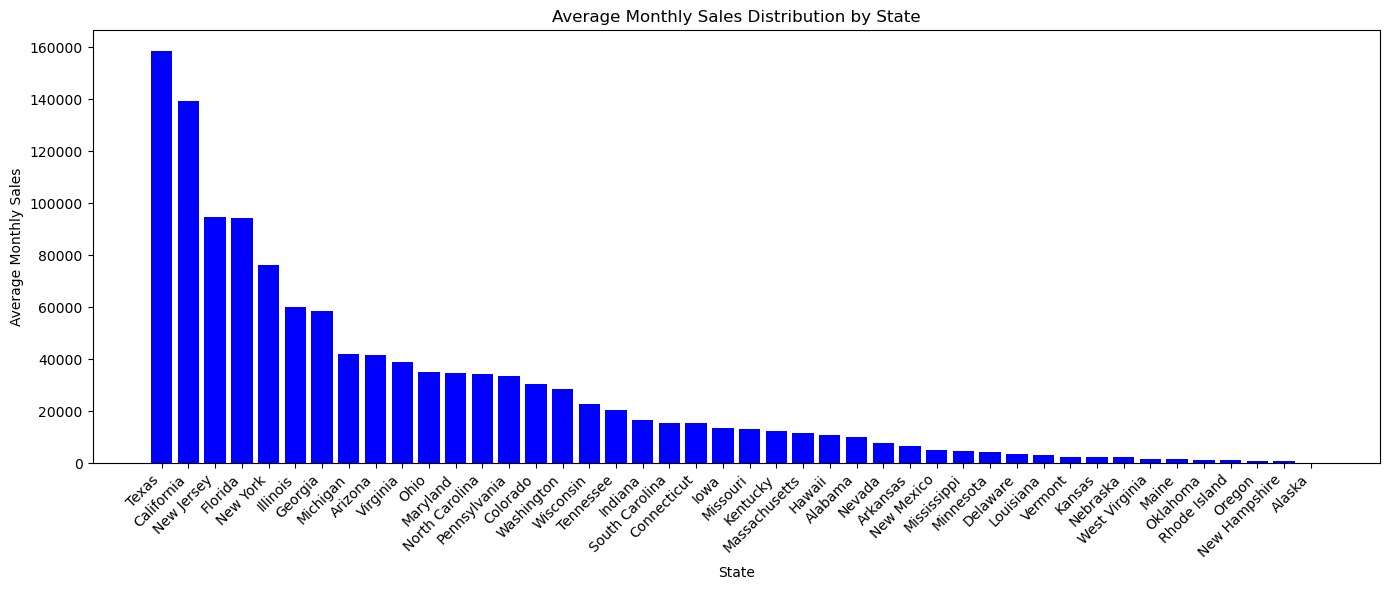

In [149]:
monthly_sales_by_state['year_month'] = pd.to_datetime(monthly_sales_by_state['year_month'])
sales_summary = monthly_sales_by_state.groupby('state').agg(
    total_sales=('amount', 'sum'),
    num_months=('year_month', 'nunique')
).reset_index()

sales_summary['avg_monthly_sales'] = sales_summary['total_sales'] / sales_summary['num_months']
sales_summary = sales_summary.sort_values(by='avg_monthly_sales', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sales_summary['state'], sales_summary['avg_monthly_sales'], color='blue')

plt.xticks(rotation=45, ha='right') 
plt.xlabel('State')
plt.ylabel('Average Monthly Sales')
plt.title('Average Monthly Sales Distribution by State')

plt.tight_layout()
plt.show()

Average Monthly Sales by State
- Consistent Performers: Large states like Texas and California show both high total sales and high average monthly sales, indicating consistent demand.

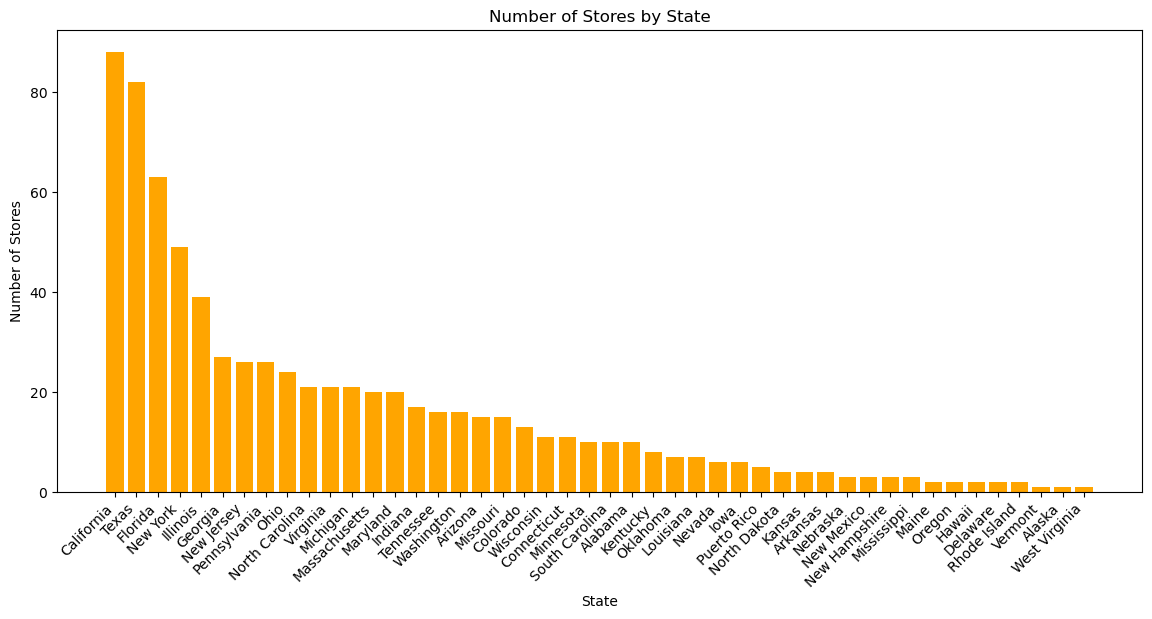

In [145]:
stores_by_state = webscrape_data.groupby('state').size().reset_index(name='store_count')
stores_by_state = stores_by_state.sort_values(by='store_count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(stores_by_state['state'], stores_by_state['store_count'], color='orange')

plt.xticks(rotation=45, ha='right') 
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.title('Number of Stores by State')

plt.show()

Number of Stores by State
- Overexpansion: States like California and Florida have many stores, which might contribute to operational overhead if individual stores do not perform well.
- Low Store Presence in Some States: States with minimal sales, such as Alaska or New Hampshire, have very few stores, which may reflect either a strategic decision or lack of market demand.

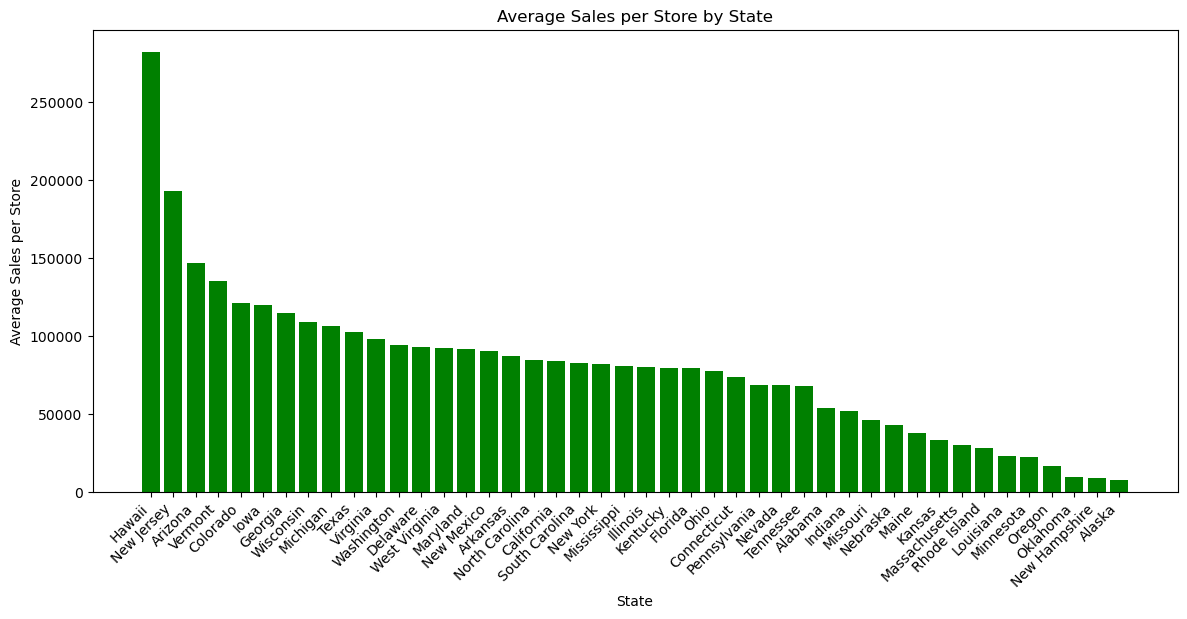

In [164]:
state_summary = pd.merge(sales_by_state, stores_by_state, on='state')
state_summary['avg_sales_per_store'] = state_summary['amount'] / state_summary['store_count']
state_summary = state_summary.sort_values(by='avg_sales_per_store', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(state_summary['state'], state_summary['avg_sales_per_store'], color='green')

plt.xticks(rotation=45, ha='right') 
plt.xlabel('State')
plt.ylabel('Average Sales per Store')
plt.title('Average Sales per Store by State')

plt.show()

Average Sales per Store by State
- Sales Efficiency in Some Regions: Hawaii and New Jersey show the highest average sales per store, suggesting that stores in these regions perform well despite fewer store locations.
- Underperformance in Heavily Saturated Markets: States like California, which have many stores, do not feature at the top for average sales per store. This could reflect overexpansion or competition.

Overall Insights for Party City:
- Operational Efficiency vs. Overexpansion: The data suggests that Party City may have overexpanded in some states like California and Florida, where individual store performance is weaker, despite high total sales.
- High-Performing Stores in Select States: New Jersey and Hawaii stand out with strong average sales per store, indicating that a leaner, more focused presence in some markets could improve profitability.
- Opportunities for Optimization: Party City might consider consolidating stores in underperforming markets or focusing on regions with high sales efficiency to boost profitability.
